# Talbot effect

In [1]:
from diffractio import plt, sp, np, um, mm, degrees, num_max_processors
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_masks_XZ import Scalar_mask_XZ
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_fields_XZ import Scalar_field_XZ
from diffractio.utils_multiprocessing import execute_multiprocessing


## Standard Talbot effect

In [2]:
x = np.linspace(-350 * um, 350 * um, 2048)
z = np.linspace(0 * um, 10 * mm, 512)
wavelength = 0.6238 * um
period = 40 * um
z_talbot = 2 * period**2 / wavelength


In [3]:
u0 = Scalar_source_X(x, wavelength)
u0.plane_wave(A=1)

t = Scalar_mask_X(x, wavelength)
t.ronchi_grating(x0=0 * um, period=40 * um, fill_factor=0.5)

talbot_effect = Scalar_field_XZ(x, z, wavelength)
talbot_effect.incident_field(u0 * t)
talbot_effect.BPM()


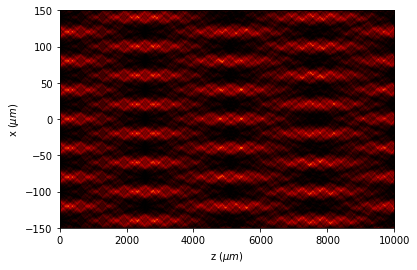

In [4]:
talbot_effect.draw(kind='intensity')
plt.ylim(-150 * um, 150 * um)


## Gauss illumination: separation of orders

In [5]:
u0 = Scalar_source_X(x, wavelength)
u0.gauss_beam(x0=0 * um, w0=150 * um, z0=0 * um, A=1, theta=0.0)

t = Scalar_mask_X(x, wavelength)
t.ronchi_grating(x0=0 * um, period=15 * um, fill_factor=0.5)

talbot_effect = Scalar_field_XZ(x, z, wavelength)
talbot_effect.incident_field(u0 * t)
talbot_effect.BPM()


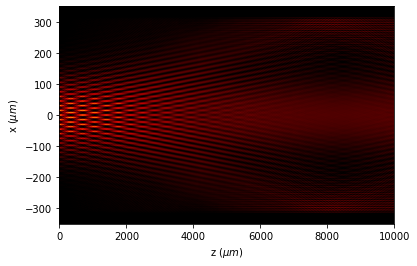

In [6]:
talbot_effect.draw(kind='intensity', logarithm=True)


## Ronchi grating at focal distance of a lens

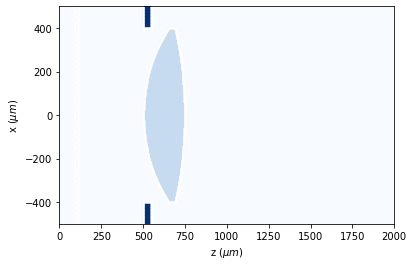

In [7]:
x0 = np.linspace(-500 * um, 500 * um, 2048 * 2)
z0 = np.linspace(0 * um, 2 * mm, 1024)
wavelength = 2 * um

u0 = Scalar_source_X(x=x0, wavelength=wavelength)
u0.plane_wave(A=1, theta=0 * degrees)

u1 = Scalar_mask_XZ(x=x0, z=z0, wavelength=wavelength)
u1.incident_field(u0)

focal, _ = u1.lens_convergent(r0=(0 * um, 500 * um),
                              aperture=800 * um,
                              radius=(.6 * mm, -1.4 * mm),
                              thickness=.25 * mm,
                              refractive_index=1.5,
                              angle=0 * degrees,
                              mask=(50 * um, 3 + 0.05j))

refractive_index = 1.5
height_grating = 20 * (refractive_index - 1) * wavelength / 2
u1.ronchi_grating(period=25 * um,
                  fill_factor=0.5,
                  length=2 * mm,
                  height=height_grating,
                  r0=(0 * um, 100 * um),
                  Dx=0 * um,
                  refractive_index=refractive_index,
                  heigth_substrate=height_grating,
                  refractive_index_substrate=refractive_index,
                  angle=0 * degrees)

u1.draw_refractive_index()

edge_matrix = u1.borders

u1.smooth_refractive_index(pixels_filtering=8, type_filter=2)


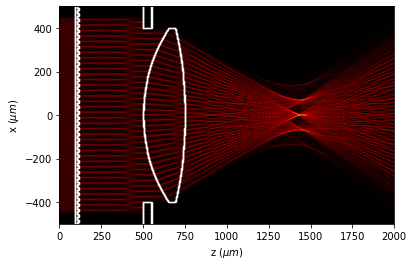

In [8]:
u1.BPM(verbose=False)
u1.draw(kind='intensity', logarithm=True, draw_borders=True)


### Desplacement of a grating in a double grating system

In [9]:
def __experiment_grating_movement__(dict_params):
    delta_x = dict_params['delta_x']
    period = dict_params['period']
    t1 = dict_params['t1']
    t2 = dict_params['t2']
    t2.ronchi_grating(period=period, x0=delta_x, fill_factor=0.5)
    u2 = t1 * t2
    return u2


In [10]:
def creation_dictionary(deltas_x, period, t1, t2):
    # create Parameters: for multiprocessing
    dict_Parameters = []
    for i, delta_x in enumerate(deltas_x):
        dict_Parameters.append(
            dict(delta_x=delta_x, period=period, t1=t1, t2=t2))
    return dict_Parameters


In [11]:
x0 = np.linspace(-400 * um, 400 * um, 1024 * 2)
wavelength = 0.85 * um
period = 50 * um
z_talbot = 2 * period**2 / wavelength
z0 = z_talbot / 2
delay = 0.001

t1 = Scalar_mask_X(x0, wavelength, info="__experiment_grating_movement__")
t1.ronchi_grating(period=period, x0=0 * um, fill_factor=0.5)
t1.RS(z=z0, new_field=False)

t2 = Scalar_mask_X(x0, wavelength, info="__experiment_grating_movement__")
t2.ronchi_grating(period=period, x0=0 * um, fill_factor=0.5)

deltas_x = np.linspace(-60 * um, 60 * um, 256)

dict_Parameters = creation_dictionary(deltas_x=deltas_x,
                                      period=period,
                                      t1=t1,
                                      t2=t2)

u_s, time_proc = execute_multiprocessing(__experiment_grating_movement__,
                                         dict_Parameters,
                                         num_max_processors - 2,
                                         verbose=True)

x = u_s[0].x


Good result: factor 8.01


num_proc: 6, time=0.24133062362670898


In [12]:
%matplotlib qt


In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
perfil = np.zeros_like(deltas_x)

h1, = ax1.plot(x, np.zeros_like(x), 'k', lw=2)
ax1.set_xlim(x[0], x[-1])
ax1.set_ylim(0, 2)
ax1.set_xlabel(r'$x (\mu m)$')

h2, = ax2.plot(deltas_x, perfil, 'k', lw=2)
ax2.set_xlim(deltas_x[0], deltas_x[-1])
ax2.set_ylim(0, .5)
ax2.set_xlabel(r'$\Delta x (\mu m)$')

incr_frames = 1
for i in range(0, len(deltas_x), incr_frames):
    intensidad = abs(u_s[i].u)**2  # sacar fuera
    perfil[i] = intensidad.mean()
    plt.suptitle(r"$\delta x={:6.2f}\,\mu m$".format(deltas_x[i]), fontsize=18)
    h1.set_ydata(intensidad)
    h2.set_ydata(perfil)
    plt.draw()
    plt.pause(0.005)


<img src="qt.png" width="400">